# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [91]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [92]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [93]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [94]:
# Let's check if there are any missing values, and if so we will handle them.
pd.isnull(data).sum()

num_orders    0
dtype: int64

No missing values found.

No duplicates were found.

In [95]:
#Let's resample the data by one hour.
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

In [96]:
#lets add the rolling mean of 7 hour.
data['num_orders'].rolling(7).mean()

datetime
2018-03-01 00:00:00           NaN
2018-03-01 01:00:00           NaN
2018-03-01 02:00:00           NaN
2018-03-01 03:00:00           NaN
2018-03-01 04:00:00           NaN
                          ...    
2018-08-31 19:00:00    167.428571
2018-08-31 20:00:00    165.714286
2018-08-31 21:00:00    169.428571
2018-08-31 22:00:00    184.714286
2018-08-31 23:00:00    185.857143
Freq: H, Name: num_orders, Length: 4416, dtype: float64

In analyzing data for trend, seasonality and noise, I divide the data into 3:
checking the data annually,
Checking the data weekly and checking the data daily.

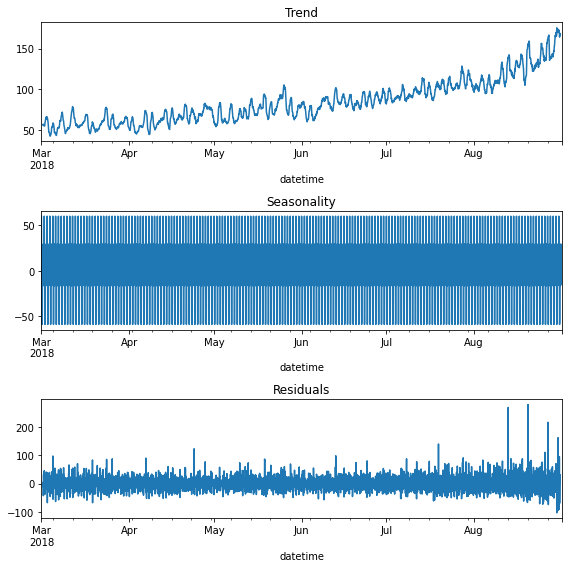

In [97]:
#Annual time series analysis.
decomposed = seasonal_decompose(data)
plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

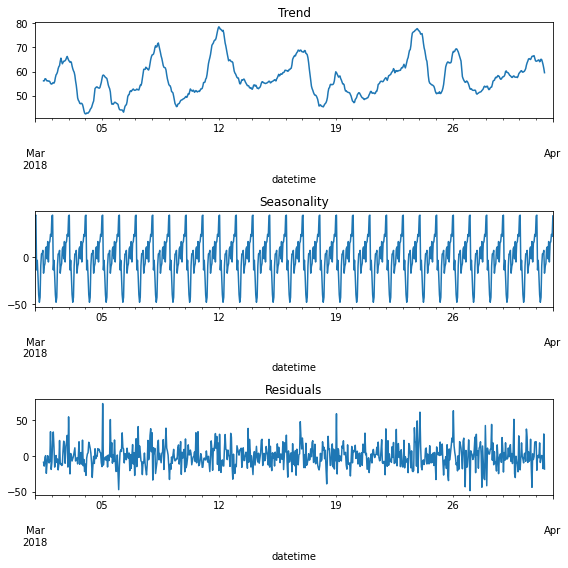

In [98]:
#Monthly time series analysis.
data1 = data['2018-03-01 00:00:00':'2018-04-01 00:00:00']
decomposed = seasonal_decompose(data1)
plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

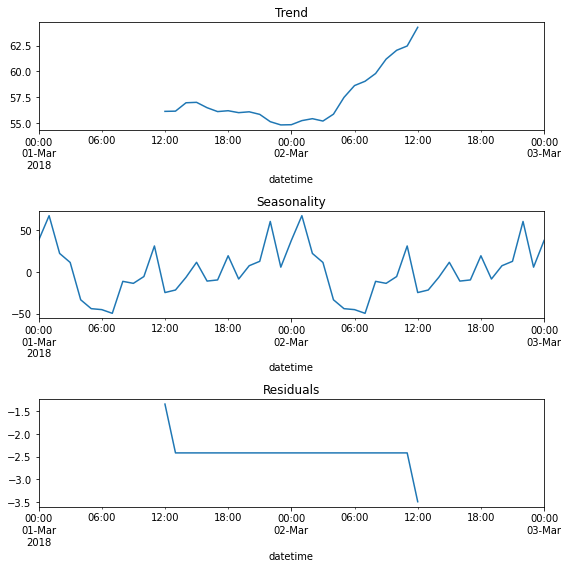

In [99]:
#Daily time series analysis.
data2 = data['2018-03-01 00:00:00':'2018-03-03 00:00:00']
decomposed = seasonal_decompose(data2)
plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Conclusions:

annual:
<br>
*It seems that there is an increase in the number of orders from March to August. <br>
*We can estimate the amplitude of the swings, which is around 100 (from -50 to +50).

weekly: 
<br>
.There seems to be an increase in the number of orders on weekends<br>
*We can estimate the amplitude of the swings, which is around 100 (from -50 to +50).

daily: 
<br>
The number of incoming orders increases from 6 in the morning, reaches a peak at 12 noon, decreases again until 6 in the evening and begins an increase that reaches its peak today at 12 at night.<br>
*We can estimate the amplitude of the swings, which is around 100 (from -50 to +50).

## Training

In [100]:
# We will write a function to define pitches in our time series.
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [101]:
make_features(data, 28, 7)
data

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,167.428571
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,276.0,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,167.428571
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,194.0,276.0,246.0,158.0,198.0,142.0,72.0,177.0,342.0,165.714286


In [102]:
# set aside 10% of train and test data for evaluation
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train, vaild = train_test_split(data, shuffle=False, test_size=0.1125)
train = train.dropna()

In [103]:
# Set features.
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
features_vaild = vaild.drop('num_orders', axis=1)
target_vaild = vaild['num_orders']

In [104]:
# We will standardize the features.
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
features_vaild = scaler.transform(features_vaild)

In [105]:
#We will check the decision tree model with different hyperparameters.
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 20): # choose hyperparameter range
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_vaild = model.predict(features_vaild) # get model predictions on validation set
    result = mean_squared_error(target_vaild, predictions_vaild)**0.5
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

print(f"RMSE of the best model on the validation set (max_depth = {best_depth}): {best_result}")

RMSE of the best model on the validation set (max_depth = 7): 50.8691921225378


In [106]:
# We will check the linear regression model.
model = LinearRegression()
model.fit(features_train, target_train)
predictions_vaild = model.predict(features_vaild)
print("RMSE for the vaild set: ", mean_squared_error(target_vaild, predictions_vaild)**0.5)

RMSE for the vaild set:  46.56019246939673


Conclusions:<br>
The desired result is below 48.

The decision tree model gave us a result of 50.86 after tuning its hyperparameters (max_depth = 4) so ​​we rejected it.<br>
The linear regression model gave us a result of 46.56 and therefore it was chosen.

6.Testing:

In [107]:
# We will test the linear regression model.
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print("RMSE for the test set: ", mean_squared_error(target_test, predictions_test)**0.5)

RMSE for the test set:  46.68687313519169


The test set is also give us good result (under 48) = 46.68.